In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import math
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.metrics import categorical_accuracy
!pip install Keras-Preprocessing
#from keras.preprocessing.image import img_to_array, load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00


In [3]:
# get all the directories of the data
train= '/content/drive/MyDrive/Colab Notebooks/primary_small/train'
valid= '/content/drive/MyDrive/Colab Notebooks/primary_small/valid'
test= '/content/drive/MyDrive/Colab Notebooks/primary_small/test'
classes = ["brightpixel", "narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]

In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [35]:
xtrain = np.load('X_train_resnet.npy')
ytrain = np.load('y_train_resnet.npy')
xtest = np.load('X_test_resnet.npy')
ytest = np.load('y_test_resnet.npy')
xval = np.load('X_val_resnet.npy')
yval = np.load('y_val_resnet.npy')

In [36]:
print(xtrain.shape)
print(ytrain.shape)

(910, 192, 192, 3)
(910, 7)


In [37]:
print(xtest.shape)
print(ytest.shape)
print(xval.shape)
print(yval.shape)

(294, 192, 192, 3)
(294, 7)
(196, 192, 192, 3)
(196, 7)


## resnet model

In [38]:
input_shape = (192, 192, 3)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet.trainable = True
for layer in resnet.layers:
    resnet.trainable = True

In [39]:
base_resnet = resnet
base_out = base_resnet.output
pool_out = Flatten()(base_out)
hidden1 = Dense(1024, activation='relu')(pool_out)
drop1 = Dropout(rate=0.2)(hidden1)
hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.2)(hidden2)

out = Dense(7, activation='softmax')(drop2)

model = Model(inputs = base_resnet.input, outputs=out)
model.compile(optimizer=RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=[categorical_accuracy])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
csv_logger = CSVLogger('resent50_finetune_full_seti_log.csv', append=True)

##history = model.fit_generator((xtrain, ytrain), epochs = 40, 
                        ##      validation_data=(xval, yval), callbacks=[csv_logger], verbose=1)
history = model.fit(xtrain, ytrain,
                epochs=40,
                validation_data=(xval, yval), callbacks=[csv_logger], verbose=1)

Epoch 1/40
29/29 [==============================] - 36s 410ms/step - loss: 2.6576 - categorical_accuracy: 0.1868 - val_loss: 1.9748 - val_categorical_accuracy: 0.1276
Epoch 2/40
29/29 [==============================] - 8s 278ms/step - loss: 1.2505 - categorical_accuracy: 0.5440 - val_loss: 2.0429 - val_categorical_accuracy: 0.1429
Epoch 3/40
29/29 [==============================] - 8s 279ms/step - loss: 0.7256 - categorical_accuracy: 0.7571 - val_loss: 2.2282 - val_categorical_accuracy: 0.1531
Epoch 4/40
29/29 [==============================] - 8s 271ms/step - loss: 0.4033 - categorical_accuracy: 0.8835 - val_loss: 2.2761 - val_categorical_accuracy: 0.1276
Epoch 5/40
29/29 [==============================] - 8s 274ms/step - loss: 0.2499 - categorical_accuracy: 0.9363 - val_loss: 2.1124 - val_categorical_accuracy: 0.1276
Epoch 6/40
29/29 [==============================] - 8s 281ms/step - loss: 0.1342 - categorical_accuracy: 0.9747 - val_loss: 3.0574 - val_categorical_accuracy: 0.1276
Epo

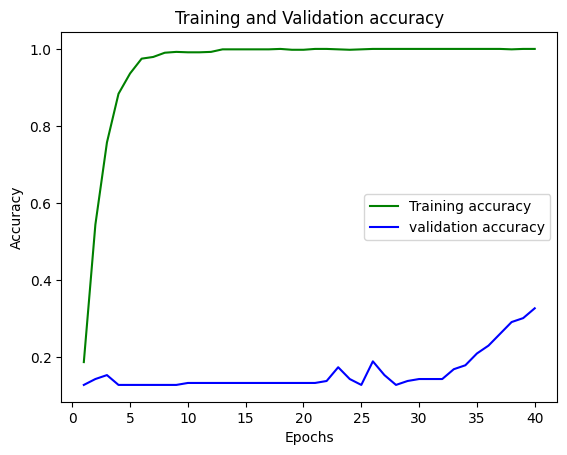

In [41]:
accuracy = history.history['categorical_accuracy']
accuracy_val= history.history['val_categorical_accuracy']
epochs= range(1,41)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('acc192.png', dpi = 300)
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.0)
test_generator = test_datagen.flow_from_directory(directory=test, classes=classes, target_size=img_dim, batch_size=1,
                                                 class_mode='categorical', interpolation='bicubic', shuffle=False, seed=42)
class_label_mapping = {v:k for k,v in test_generator.class_indices.items()}
test_data = [next(test_generator) for i in range(700)]
test_data_X = [data[0] for data in test_data] 
test_data_X = np.array(np.squeeze(test_data_X, axis=1))
test_data_y = np.array([fname.split('/')[0] for fname in test_generator.filenames])
class_labels = list(set(test_data_y))

test_data_X.shape, test_data_y.shape

Found 700 images belonging to 7 classes.


((700, 192, 192, 3), (700,))

In [ ]:
def evaluate_model_results(model, test_data, test_labels, 
                           class_label_mapping, class_labels):
    predictions = model.predict(test_data, verbose=1)
    prediction_labels = [class_label_mapping[idx] for idx in predictions.argmax(axis=1)]
    print(classification_report(y_true=test_labels, y_pred=prediction_labels))
    return pd.DataFrame(confusion_matrix(y_true=test_labels, y_pred=prediction_labels, labels=class_labels),
                        index=class_labels, columns=class_labels)

In [ ]:
evaluate_model_results(model, test_data_X, test_data_y, class_label_mapping, class_labels)

22/22 [==============================] - 4s 108ms/step
                                precision    recall  f1-score   support

                   brightpixel       0.96      0.80      0.87       100
                    narrowband       0.83      0.98      0.90       100
                 narrowbanddrd       0.93      0.80      0.86       100
                         noise       0.76      0.95      0.84       100
        squarepulsednarrowband       0.90      0.77      0.83       100
                      squiggle       0.97      0.95      0.96       100
squigglesquarepulsednarrowband       0.88      0.91      0.89       100

                      accuracy                           0.88       700
                     macro avg       0.89      0.88      0.88       700
                  weighted avg       0.89      0.88      0.88       700



,squigglesquarepulsednarrowband,squiggle,brightpixel,squarepulsednarrowband,noise,narrowband,narrowbanddrd
squigglesquarepulsednarrowband,91,2,0,7,0,0,0
squiggle,0,95,0,0,1,4,0
brightpixel,1,0,80,1,17,0,1
squarepulsednarrowband,11,0,0,77,5,5,2
noise,1,0,3,0,95,0,1
narrowband,0,0,0,0,0,98,2
narrowbanddrd,0,1,0,1,7,11,80


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict(test_generator,steps = nb_samples)
predictions = predict.argmax(axis = 1)
true_labels = test_generator.classes

700/700 [==============================] - 17s 22ms/step


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
 

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion22.png', dpi =300)
    plt.show()
    

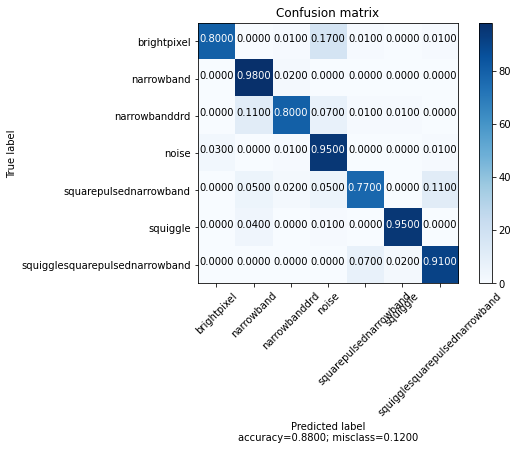

In [ ]:
import sklearn
import itertools
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

cm = sklearn.metrics.confusion_matrix(true_labels, predictions)
target_names = ['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband']
k = plot_confusion_matrix(cm,target_names)


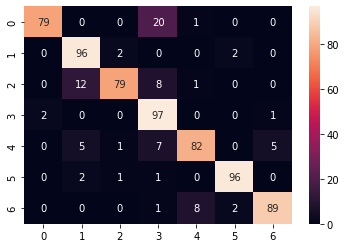

In [ ]:
sns.heatmap(cm, annot = True, fmt = 'd')